In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as time

import torch
from astropy.io import fits
from astropy.utils.data import download_file



from mpol import (
    coordinates,
    crossval,
    datasets,
    gridding,
    images,
    fourier,
    losses,
    precomposed,
)

from training_func import train, seed_from_dirty_image

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [18]:
# input parameters
###########################################################################################################################################
fname = '../data/visibilities/RDor_spw3_fixvis.npz' # path to the .npz file containing the observed visibilities
cell_size = 0.001 # arcseconds
npix = 512 # number of pixels per image axis

learning_rate = 0.3 # learning rate for the optimizer
# n_iter = 25 # number of iterations for the optimizer

start_from_dirty_image = False # If True, the initial BaseCube image is set to the dirty image, else to the default flat image.
###########################################################################################################################################

In [19]:
# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = averager.to_pytorch_dataset(max_scatter=1.5)

dset

GriddedDataset()

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

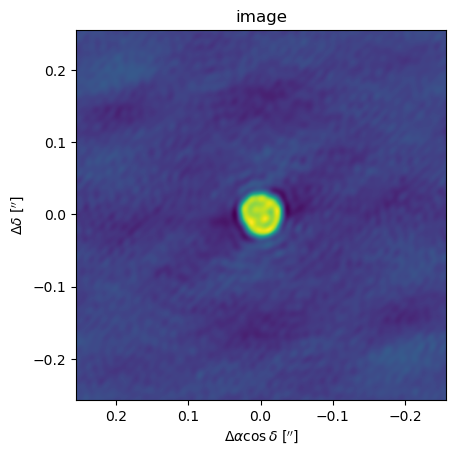

In [20]:
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# Show the dirty image
img, beam = imager.get_dirty_image(weighting="uniform", robust=0.0, max_scatter=1.5)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

/Users/behzadbojnordiarbab/opt/anaconda3/lib/python3.9/site-packages/mpol/gridding.py:863: RuntimeWarning: Visibility scatter exceeds ``max_scatter``:1.2, indicating a potential problem with data weights. Consider inspecting weights using CASA tools before exporting visibilities for use with MPoL. Median real scatter: 1.4570461574546718 x sigma. Median imag scatter: 1.4253737596622424 x sigma.
  warnings.warn(


(-0.1, 0.1)

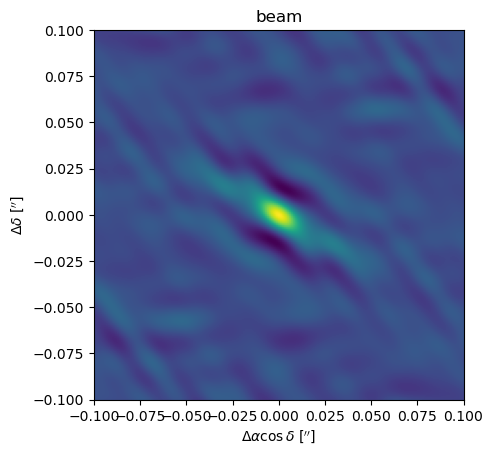

In [21]:
# Show the dirty beam
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(beam), **kw)
ax.set_title("beam")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

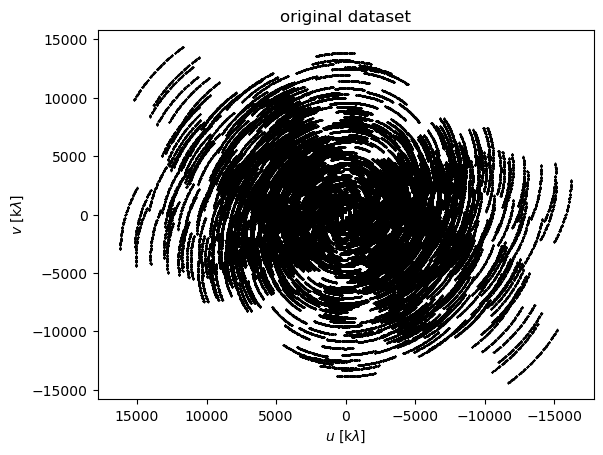

In [22]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uu, -vv, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("original dataset")
ax.invert_xaxis()

In [23]:
# create a radial and azimuthal partition
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 10
cv = crossval.DartboardSplitGridded(dset, k, dartboard=dartboard, seed=42)

k_fold_datasets = [(train, test) for (train, test) in cv]

k_fold_datasets[0][0].vis_gridded.shape

# k_fold_datasets[0][0].ground_mask[0]

torch.Size([1, 512, 512])

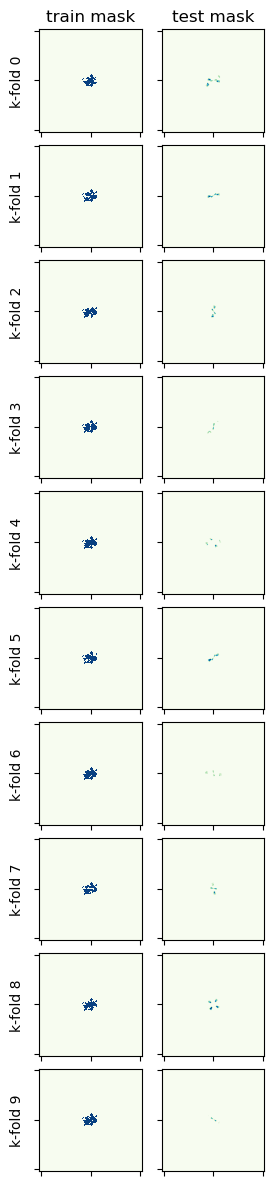

In [24]:
fig, ax = plt.subplots(nrows=k, ncols=2, figsize=(3, 15))

for i, (train_subset, test_subset) in enumerate(k_fold_datasets):

    # train_subset and test_subset are `GriddedDataset`s

    train_mask = train_subset.ground_mask[0]
    test_mask = test_subset.ground_mask[0]
    # print("extent:", coords.vis_ext)

    ax[i, 0].imshow(
        train_mask.detach().numpy(),
        interpolation="none",
        origin="lower",
        extent=coords.vis_ext,
        cmap="GnBu",
    )

    ax[i, 1].imshow(
        test_mask.detach().numpy(), origin="lower", extent=coords.vis_ext, cmap="GnBu"
    )

    ax[i, 0].set_ylabel("k-fold {:}".format(i))

ax[0, 0].set_title("train mask")
ax[0, 1].set_title("test mask")

for a in ax.flatten():
    a.xaxis.set_ticklabels([])
    a.yaxis.set_ticklabels([])
    # print the limits of x axis
    # print(a.get_xlim())
    # a.set_xlim(-20000, 20000)
    # a.set_ylim(-20000, 20000)

fig.subplots_adjust(left=0.15, hspace=0.0, wspace=0.2)

In [10]:
def test(model, dset):
    model.train(False)
    # evaluate test score
    vis = model()
    loss = losses.nll_gridded(vis, dset)
    return loss.item()

In [11]:
def cross_validate(config, start_from_dirty_image=False):
    """
    config is a dictionary that should contain ``lr``, ``lambda_sparsity``, ``lambda_TV``, ``epochs``
    """
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # create a new model and optimizer for this k_fold
        rml = precomposed.SimpleNet(coords=coords, nchan=train_dset.nchan)
        if start_from_dirty_image:
            rml.load_state_dict(torch.load("RML_loop_outputs/dirty_image_model.pt"))
        optimizer = torch.optim.Adam(rml.parameters(), lr=config["lr"])

        # train for a while
        # train(rml, train_dset, config, optimizer)
        loss_tracker = train(rml=rml, dset=train_dset, hyperparams_config=config, optimizer=optimizer)
        # evaluate the test metric
        test_scores.append(test(rml, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    return test_score

In [12]:
def train_and_image(pars, start_from_dirty_image=False):
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    if start_from_dirty_image:
        rml.load_state_dict(torch.load("RML_loop_outputs/dirty_image_model.pt"))
    print("Model created")
    optimizer = torch.optim.Adam(rml.parameters(), lr=pars["lr"])
    writer = SummaryWriter()
    # train(rml, dset, pars, optimizer, writer=writer)
    print("Training the model...")
    loss_tracker = train(rml=rml, dset=dset, hyperparams_config=pars, optimizer=optimizer, writer=writer)
    writer.close()

    img_ext = rml.coords.img_ext
    fig, ax = plt.subplots()
    ax.imshow(
        np.squeeze(rml.icube.sky_cube.detach().numpy()), origin="lower", extent=img_ext
    )
    return fig, ax

### Train with a given set of parameters

Here we can test different parameters

Starting the optimisation loop with 100 iterations to optimise the initial model image (BaseCube) based on the dirty image...
Optimised initial model image (BaseCube) based on the dirty image saved to: RML_loop_outputs/dirty_image_model.pt

Model created
Training the model...


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

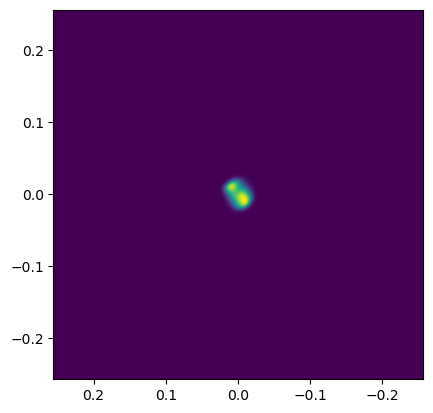

In [56]:
torch.set_num_threads(10)
pars = {'lr': 0.3,
        'lambda_sparsity': 1e-5,
        'lambda_TV': 1e-8,
        'entropy': 1e-2,
        'prior_intensity': 1.0e-7,
        'TSV': 1e-6,
        "epochs": 1000}

coords = coordinates.GridCoords(
    cell_size=cell_size, npix=npix)  
rml_dim = seed_from_dirty_image(learning_rate_dim=0.5, n_iter_dim=100, coords=coords, img=img, dset=dset, plot_loss_per_iteration=False, plot_final_seed=False)

train_and_image(pars, start_from_dirty_image=True)



In [25]:
def interactive_train_and_image(lr=0.1, log_sparsity=-5, log_TV=-5, log_entropy=-1, log_prior_intensity=-1, log_TSV=-5, epochs=500, start_from_dirty_image=False, plot_losstracker=False):
    start_time=time.time()
    coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)
    regularizers=['lambda_sparsity', 'lambda_TV', 'entropy', 'prior_intensity', 'TSV']
    pars = {'lr': lr,
        'lambda_sparsity': 10**log_sparsity,
        'lambda_TV': 10**log_TV,
        'entropy': 10**log_entropy,
        'prior_intensity': 10**log_prior_intensity,
        'TSV': 10**log_TSV,
        "epochs": epochs}
    
    for regularizer in regularizers:
        if pars[regularizer] <= 10**-5:
            pars[regularizer] = 0
    
    
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    if start_from_dirty_image:
        rml.load_state_dict(torch.load("RML_loop_outputs/dirty_image_model.pt"))
    optimizer = torch.optim.Adam(rml.parameters(), lr=pars["lr"])

    writer = SummaryWriter()
    loss_tracker = train(rml=rml, dset=dset, hyperparams_config=pars, optimizer=optimizer, writer=writer)
    if plot_losstracker:
        # plot loss_tracker
        fig, ax = plt.subplots()
        ax.plot(loss_tracker)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
    writer.close()

    img_ext = rml.coords.img_ext
    fig, ax = plt.subplots()
    ax.imshow(
        np.squeeze(rml.icube.sky_cube.detach().numpy()), origin="lower", extent=img_ext
    )
    print(pars)
    print("Total time: {:.2f} s".format(time.time()-start_time))
    return

In [26]:
from ipywidgets import interact
torch.set_num_threads(10)
coords = coordinates.GridCoords(
    cell_size=cell_size, npix=npix)  
rml_dim = seed_from_dirty_image(learning_rate_dim=0.5, n_iter_dim=100, coords=coords, img=img, dset=dset, plot_loss_per_iteration=False, plot_final_seed=False)

interact(interactive_train_and_image, 
         lr=(0.1, 1.0, 0.1),
         log_sparsity=(-5, 0, 0.5),
         log_TV=(-5, 0, 0.5),
         log_entropy=(-5, 0, 0.1),
         log_prior_intensity=(-5, 0, 0.5),
         log_TSV=(-5, 0, 0.5),
         epochs=[100, 250, 500, 1000, 2000, 5000, 10000],
         start_from_dirty_image=False)

Starting the optimisation loop with 100 iterations to optimise the initial model image (BaseCube) based on the dirty image...
Optimised initial model image (BaseCube) based on the dirty image saved to: RML_loop_outputs/dirty_image_model.pt



interactive(children=(FloatSlider(value=0.1, description='lr', max=1.0, min=0.1), FloatSlider(value=-5.0, desc…

<function __main__.interactive_train_and_image(lr=0.1, log_sparsity=-5, log_TV=-5, log_entropy=-1, log_prior_intensity=-1, log_TSV=-5, epochs=500, start_from_dirty_image=False, plot_losstracker=False)>

In [253]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

cv_filename = '../results/cv dataframes/cv_dataframe_500.csv'
# Define missing variables
lambda_sparsity_space = np.logspace(-6, -1, 5)
# lambda_TV_space = np.logspace(-8, -4, 3)
lambda_TV_space = np.array([0])
entropy_space = np.logspace(-2, -1, 5)
TSV_space = np.logspace(-6, -1, 5)
torch.set_num_threads(8)
coords = coordinates.GridCoords(
    cell_size=cell_size, npix=npix)  

rml_dim = seed_from_dirty_image(learning_rate_dim=0.5, n_iter_dim=100, coords=coords, img=img, dset=dset, plot_loss_per_iteration=False, plot_final_seed=False)

# Fix code block
cv_dataframe = pd.DataFrame(columns=['lambda_sparsity', 'lambda_TV', 'entropy', 'TSV', 'cross_val_score'])
parameter_total = len(lambda_sparsity_space)*len(lambda_TV_space)*len(entropy_space)*len(TSV_space)
start_time = time.time()
for sparsity_index, lambda_sparsity in enumerate(lambda_sparsity_space):
    for TV_index, lambda_TV in enumerate(lambda_TV_space):
        for entropy_index, entropy in enumerate(entropy_space):
            for TSV_index, TSV in enumerate(TSV_space):
                parameter_count=sparsity_index*len(lambda_TV_space)*len(entropy_space)*len(TSV_space)+TV_index*len(entropy_space)*len(TSV_space)+entropy_index*len(TSV_space)+TSV_index+1
                # print(f"[{parameter_count}/{parameter_total}]")
                run_time_start = time.time()
                pars = {'lr': 1,
                        'lambda_sparsity': lambda_sparsity,
                        'lambda_TV': lambda_TV,
                        'entropy': entropy,
                        'prior_intensity': 0,
                        'TSV': TSV,
                        "epochs": 500}
                cv_score = cross_validate(pars, start_from_dirty_image=True)
                print("[{}/{}] --> CV: {:.2f}, log_TSV:{:.1e}, log_entropy:{:.1e}, log_TV:{:.1e}, log_sparsity:{:.1e}".format(parameter_count, parameter_total, cv_score, np.log10(TSV), np.log10(entropy), np.log10(lambda_TV), np.log10(lambda_sparsity)))
                cv_dataframe = pd.concat([cv_dataframe, pd.DataFrame({'lambda_sparsity': lambda_sparsity, 'lambda_TV': lambda_TV, 'entropy': entropy, 'TSV': TSV, 'cross_val_score': cv_score}, index=[0])], ignore_index=True)
                # train_and_image(pars)
                run_time_end = time.time()
                predicted_time = (time.time()-start_time)*(parameter_total-parameter_count)/(parameter_count)
                print("runtime: {:.1f} seconds \t remaining time: {:.1f} minutes\n".format(run_time_end-run_time_start, predicted_time/60))

end_time = time.time()
print("Time taken for cross validation:{:.2f} minutes".format((end_time-start_time)/60))
cv_dataframe.to_csv(cv_filename, index=True)

Starting the optimisation loop with 100 iterations to optimise the initial model image (BaseCube) based on the dirty image...
Optimised initial model image (BaseCube) based on the dirty image saved to: RML_loop_outputs/dirty_image_model.pt

[1/125] --> CV: 157916.14, log_TSV:-6.0e+00, log_entropy:-2.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
runtime: 16.6 seconds 	 remaining time: 34.3 minutes

[2/125] --> CV: 157827.51, log_TSV:-4.8e+00, log_entropy:-2.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
runtime: 15.0 seconds 	 remaining time: 32.4 minutes

[3/125] --> CV: 157152.92, log_TSV:-3.5e+00, log_entropy:-2.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
runtime: 15.4 seconds 	 remaining time: 31.8 minutes

[4/125] --> CV: 152996.64, log_TSV:-2.2e+00, log_entropy:-2.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
runtime: 15.6 seconds 	 remaining time: 31.6 minutes

[5/125] --> CV: 148462.87, log_TSV:-1.0e+00, log_entropy:-2.0e+00, log_TV:-8.0e+00, log_sparsity:-6.0e+00
runtime: 17.4

In [254]:
cv_dataframe.to_csv(cv_filename, index=True)

In [255]:
cv_dataframe

,lambda_sparsity,lambda_TV,entropy,TSV,cross_val_score
0,1.00e-06,1.00e-08,1.00e-02,1.00e-06,1.58e+05
1,1.00e-06,1.00e-08,1.00e-02,1.78e-05,1.58e+05
2,1.00e-06,1.00e-08,1.00e-02,3.16e-04,1.57e+05
3,1.00e-06,1.00e-08,1.00e-02,5.62e-03,1.53e+05
4,1.00e-06,1.00e-08,1.00e-02,1.00e-01,1.48e+05
...,...,...,...,...,...
120,1.00e-01,1.00e-08,1.00e-01,1.00e-06,1.66e+05
121,1.00e-01,1.00e-08,1.00e-01,1.78e-05,1.66e+05
122,1.00e-01,1.00e-08,1.00e-01,3.16e-04,1.66e+05
123,1.00e-01,1.00e-08,1.00e-01,5.62e-03,1.66e+05


In [256]:
cv_dataframe.sort_values(by='cross_val_score', ascending=True)

,lambda_sparsity,lambda_TV,entropy,TSV,cross_val_score
4,1.00e-06,1.00e-08,1.00e-02,1.00e-01,1.48e+05
54,3.16e-04,1.00e-08,1.00e-02,1.00e-01,1.48e+05
29,1.78e-05,1.00e-08,1.00e-02,1.00e-01,1.48e+05
78,5.62e-03,1.00e-08,1.00e-02,5.62e-03,1.49e+05
79,5.62e-03,1.00e-08,1.00e-02,1.00e-01,1.49e+05
...,...,...,...,...,...
124,1.00e-01,1.00e-08,1.00e-01,1.00e-01,1.66e+05
123,1.00e-01,1.00e-08,1.00e-01,5.62e-03,1.66e+05
122,1.00e-01,1.00e-08,1.00e-01,3.16e-04,1.66e+05
121,1.00e-01,1.00e-08,1.00e-01,1.78e-05,1.66e+05


In [257]:
idx = cv_dataframe['cross_val_score'].idxmin()
print("lowest cross validation score:\n", cv_dataframe.loc[idx])

lowest cross validation score:
 lambda_sparsity   1.00e-06
lambda_TV         1.00e-08
entropy           1.00e-02
TSV               1.00e-01
cross_val_score   1.48e+05
Name: 4, dtype: float64


Model created
Training the model...


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

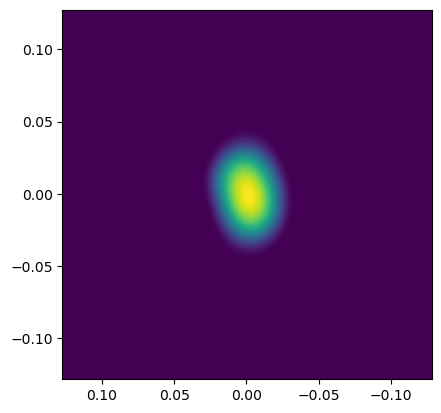

In [272]:
pars = {'lr': 1,
        'lambda_sparsity': cv_dataframe['lambda_sparsity'][idx],
        'lambda_TV': cv_dataframe['lambda_TV'][idx],
        'entropy': cv_dataframe['entropy'][idx],
        'prior_intensity': 1.0e-7,
        'TSV': cv_dataframe['TSV'][idx],
        "epochs": 600}

train_and_image(pars)

     lambda_sparsity  entropy      TSV  cross_val_score
4           1.00e-06 1.00e-02 1.00e-01         1.48e+05
54          3.16e-04 1.00e-02 1.00e-01         1.48e+05
29          1.78e-05 1.00e-02 1.00e-01         1.48e+05
78          5.62e-03 1.00e-02 5.62e-03         1.49e+05
79          5.62e-03 1.00e-02 1.00e-01         1.49e+05
..               ...      ...      ...              ...
124         1.00e-01 1.00e-01 1.00e-01         1.66e+05
123         1.00e-01 1.00e-01 5.62e-03         1.66e+05
122         1.00e-01 1.00e-01 3.16e-04         1.66e+05
121         1.00e-01 1.00e-01 1.78e-05         1.66e+05
120         1.00e-01 1.00e-01 1.00e-06         1.66e+05

[125 rows x 4 columns]


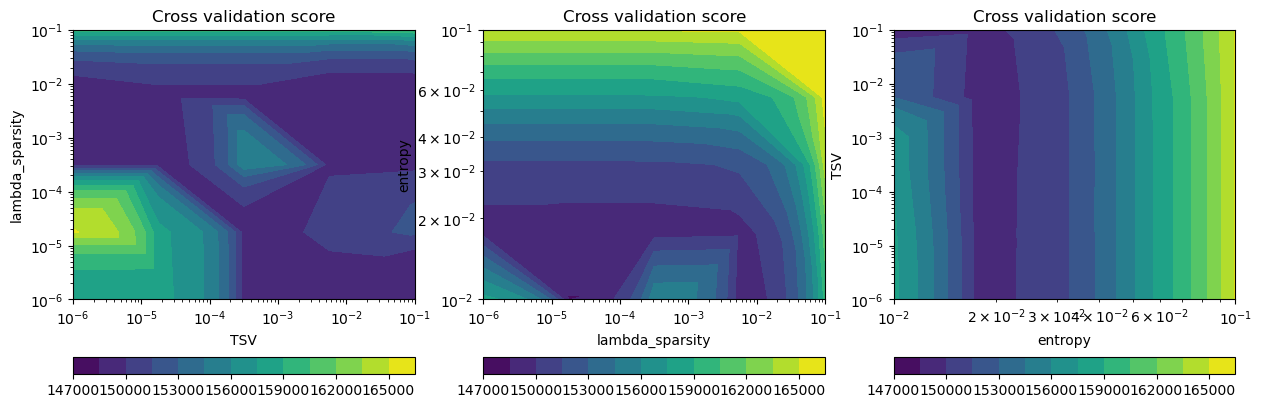

In [16]:
pd.set_option('display.float_format', lambda x: '%.2e' % x)
interest_cols = ['lambda_sparsity', 'entropy', 'TSV', 'cross_val_score']
# read cv_dataframe
# cv_filename="../results/cv dataframes/cv_dataframe_500.csv"
df = pd.read_csv(cv_filename, index_col=0)
df_interest = df[interest_cols]
interest_cols = ['lambda_sparsity', 'entropy', 'TSV']
print(df_interest.sort_values(by='cross_val_score', ascending=True))

# plot a contour plot for each two parameter combination and the cross validation score. 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(interest_cols):
    X = df_interest[interest_cols[i-1]]
    Y = df_interest[interest_cols[i]]
    Z = df_interest['cross_val_score']
    ax[i].tricontourf(X, Y, Z, levels=14, cmap='RdYlBu')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel(interest_cols[i-1])
    ax[i].set_ylabel(interest_cols[i])
    ax[i].set_title('Cross validation score')
    fig.colorbar(ax[i].tricontourf(X, Y, Z, levels=14), ax=ax[i], orientation='horizontal')
plt.show()